# Predicting Infection and  Mortality Risk using Machine Learning

In [ ]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout,LeakyReLU
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from sklearn.externals import joblib 
from keras.callbacks import History 
from keras.models import load_model


In [49]:
df = pd.read_csv("master_dataset.csv",index_col = False)

In [50]:
df.head()

,survey_date,region,country,ip_latitude,ip_longitude,ip_accuracy,sex,age,height,weight,...,lung_disease,diabetes,hiv_positive,hypertension,other_chronic,prescription_medication,opinion_infection,opinion_mortality,risk_infection,risk_mortality
0,2020-03-24,NaN,CA,49.3019,-124.8800,1.0,male,10_20,174,68,...,0,0,0,0,0,NaN,NaN,NaN,9.0,0.500
1,2020-03-26,NaN,US,40.5595,-112.0078,5.0,male,30_40,184,118,...,0,1,0,1,1,NaN,NaN,NaN,52.0,20.859
2,2020-03-25,NaN,CA,49.1901,-123.2516,1.0,male,30_40,180,88,...,0,0,0,0,0,NaN,NaN,NaN,9.0,0.500
3,2020-03-25,OC,AU,-37.8620,144.9410,20.0,female,20_30,172,90,...,0,0,0,0,0,NaN,NaN,NaN,9.0,0.500
4,2020-03-25,NaN,US,43.1716,-77.5326,5.0,female,0_10,122,44,...,0,0,0,0,0,NaN,NaN,NaN,12.0,0.500


In [51]:
len(df)

675916

# Data Pre-Processing

#### 1) Keeping unknown blood group as new category and removing prescription medicine
#### 2) Randomly choosing age between specified age bracket label
#### 3) Removing the rows with NaN values
#### 4) Converting (-2,2) rating to (1,5) rating

In [52]:
df['blood_type'].unique()

array(['unknown', 'bn', 'op', 'ap', 'bp', 'on', 'abn', 'abp', 'an'],
      dtype=object)

In [53]:
df.columns

Index(['survey_date', 'region', 'country', 'ip_latitude', 'ip_longitude',
       'ip_accuracy', 'sex', 'age', 'height', 'weight', 'bmi', 'blood_type',
       'smoking', 'alcohol', 'cannabis', 'amphetamines', 'cocaine', 'lsd',
       'mdma', 'contacts_count', 'house_count', 'text_working',
       'rate_government_action', 'rate_reducing_risk_single',
       'rate_reducing_risk_house', 'rate_reducing_mask', 'covid19_positive',
       'covid19_symptoms', 'covid19_contact', 'asthma', 'kidney_disease',
       'compromised_immune', 'heart_disease', 'lung_disease', 'diabetes',
       'hiv_positive', 'hypertension', 'other_chronic',
       'prescription_medication', 'opinion_infection', 'opinion_mortality',
       'risk_infection', 'risk_mortality'],
      dtype='object')

In [54]:
keep_cols = ['sex', 'age', 'height', 'weight', 'blood_type',
       'smoking', 'alcohol', 'cannabis', 'amphetamines', 'cocaine', 'lsd',
       'mdma', 'contacts_count', 'house_count',
       'rate_government_action', 'rate_reducing_risk_single',
       'rate_reducing_risk_house', 'rate_reducing_mask',
       'covid19_symptoms', 'covid19_contact', 'asthma', 'kidney_disease',
       'compromised_immune', 'heart_disease', 'lung_disease', 'diabetes',
       'hiv_positive', 'hypertension', 'other_chronic',
       'risk_infection', 'risk_mortality']

In [55]:
#newfeatures = sparse.hstack((textfeatures, other_features)).tocsr()

In [56]:
df = df[keep_cols]

In [57]:
#converting age bracket range to single age

df['age']= df['age'].apply(lambda row: random.choice(range(int(row.split("_")[0]),int(row.split("_")[1]))))

In [58]:
categorical_cols = ['sex', 'blood_type',
       'smoking', 'alcohol', 'cannabis', 'amphetamines', 'cocaine', 'lsd',
       'mdma', 'contacts_count', 'house_count',
       'rate_government_action', 'rate_reducing_risk_single',
       'rate_reducing_risk_house', 'rate_reducing_mask',
       'covid19_symptoms', 'covid19_contact', 'asthma', 'kidney_disease',
       'compromised_immune', 'heart_disease', 'lung_disease', 'diabetes',
       'hiv_positive', 'hypertension', 'other_chronic']

In [59]:
for i in categorical_cols:
    print("unique values for {}: {}".format(i,df[i].unique()))

unique values for sex: ['male' 'female' 'other']
unique values for blood_type: ['unknown' 'bn' 'op' 'ap' 'bp' 'on' 'abn' 'abp' 'an']
unique values for smoking: [nan 'never' 'yesheavy' 'quit0' 'yeslight' 'quit5' 'quit10' 'yesmedium'
 'vape']
unique values for alcohol: [nan  0.  2. -1.  4. 13.  3. 10.  1. 11.  6. 14.  5.  7. 12.  8.  9.]
unique values for cannabis: [nan -1.  0.  2. 27. 25.  5. 20. 28.  4. 15.  1.  3.  6. 10. 14. 21. 22.
 18. 17.  8. 23. 24.  7. -2. 12. 26. 16.  9. 13. 11. 19.]
unique values for amphetamines: [nan -1.  0. 20.  3.  2. 15.  1. 28. -2. 25. 21.  4. 12.  5.  7.  6. 10.
 11. 14. 23. 24. 26.  8.  9. 27. 13. 16. 22. 18. 19. 17.]
unique values for cocaine: [nan -1.  0.  4.  3.  2.  1. -2.  7.  8. 28. 23. 15.  6. 12.  5. 10. 14.
 20. 13. 16. 27. 25.  9. 26. 11. 24. 22. 19. 17. 18. 21.]
unique values for lsd: [nan -1.  0.  1.  3. -2.  2. 10.  5.  4.  7. 18.  8. 13. 27. 20.  6. 21.
 28. 11. 14. 24.  9. 12. 22. 19. 17. 23. 26. 25. 15. 16.]
unique values for mdma: [nan

In [60]:
#Removing nan values

df= df.dropna(subset=['smoking','cannabis','amphetamines','cocaine','lsd','mdma','contacts_count','risk_infection', 'risk_mortality'])


In [61]:
len(df)

628605

In [62]:
for i in categorical_cols:
    print("unique values for {}: {}".format(i,df[i].unique()))

unique values for sex: ['female' 'male' 'other']
unique values for blood_type: ['op' 'on' 'an' 'unknown' 'bp' 'bn' 'ap' 'abp' 'abn']
unique values for smoking: ['never' 'yesheavy' 'quit0' 'yeslight' 'quit5' 'quit10' 'yesmedium' 'vape']
unique values for alcohol: [ 0.  2. -1.  4. 13.  3. 10.  1. 11.  6. 14.  5.  7. 12.  8.  9.]
unique values for cannabis: [-1.  0.  2. 27. 25.  5. 20. 28.  4.  1.  3.  6. 10. 14. 21. 22. 18. 17.
 15.  8. 23.  7. 24. -2. 12. 16.  9. 26. 13. 11. 19.]
unique values for amphetamines: [-1.  0. 20.  3.  2.  1. 28. 25. 21.  4. 15. 12.  5.  7.  6. 10. -2. 11.
 23. 14. 24. 26.  8. 27. 13. 16. 18. 22.  9. 19. 17.]
unique values for cocaine: [-1.  0.  3.  2.  1.  4.  7.  8. 28. -2. 23. 15.  6. 12.  5. 10. 14. 20.
 13. 16. 27. 25. 26. 11. 24.  9. 22. 17. 19. 18. 21.]
unique values for lsd: [-1.  0.  1.  3. -2.  2. 10.  5.  4.  7. 18.  8. 27.  6. 21. 28. 11. 14.
 24. 20.  9. 12. 22. 19. 13. 17. 23. 26. 25. 15. 16.]
unique values for mdma: [-1.  0.  1.  2. 28.  4. 20. 

In [63]:
#Modifiying smoking column for our convinience

df['smoking'] = df['smoking'].str.replace('yesheavy','heavy')
df['smoking'] = df['smoking'].str.replace('yeslight','light')
df['smoking'] = df['smoking'].str.replace('yesmedium','medium')

In [64]:
df['smoking'].unique()

array(['never', 'heavy', 'quit0', 'light', 'quit5', 'quit10', 'medium',
       'vape'], dtype=object)

In [65]:
df.dtypes

sex                           object
age                            int64
height                         int64
weight                         int64
blood_type                    object
smoking                       object
alcohol                      float64
cannabis                     float64
amphetamines                 float64
cocaine                      float64
lsd                          float64
mdma                         float64
contacts_count               float64
house_count                    int64
rate_government_action         int64
rate_reducing_risk_single      int64
rate_reducing_risk_house       int64
rate_reducing_mask           float64
covid19_symptoms               int64
covid19_contact                int64
asthma                         int64
kidney_disease                 int64
compromised_immune             int64
heart_disease                  int64
lung_disease                   int64
diabetes                       int64
hiv_positive                   int64
h

In [66]:
# converting (-2,2) rating to (1,5) rating

map_dict = {-2:1, -1:2, 0:3, 1:4, 2:5}

df['rate_government_action'] = df['rate_government_action'].apply(lambda row: map_dict[row])
df['rate_reducing_risk_single']= df['rate_reducing_risk_single'].apply(lambda row: map_dict[row])
df['rate_reducing_risk_house']= df['rate_reducing_risk_house'].apply(lambda row: map_dict[row])

In [67]:
to_int_list = ['alcohol','cannabis','amphetamines','cocaine',
               'lsd','mdma','contacts_count','rate_reducing_mask']
for i in to_int_list:
    df[i] = df[i].apply(lambda row: int(row))


In [68]:
for i in categorical_cols:
    print("unique values for {}: {}".format(i,df[i].unique()))

unique values for sex: ['female' 'male' 'other']
unique values for blood_type: ['op' 'on' 'an' 'unknown' 'bp' 'bn' 'ap' 'abp' 'abn']
unique values for smoking: ['never' 'heavy' 'quit0' 'light' 'quit5' 'quit10' 'medium' 'vape']
unique values for alcohol: [ 0  2 -1  4 13  3 10  1 11  6 14  5  7 12  8  9]
unique values for cannabis: [-1  0  2 27 25  5 20 28  4  1  3  6 10 14 21 22 18 17 15  8 23  7 24 -2
 12 16  9 26 13 11 19]
unique values for amphetamines: [-1  0 20  3  2  1 28 25 21  4 15 12  5  7  6 10 -2 11 23 14 24 26  8 27
 13 16 18 22  9 19 17]
unique values for cocaine: [-1  0  3  2  1  4  7  8 28 -2 23 15  6 12  5 10 14 20 13 16 27 25 26 11
 24  9 22 17 19 18 21]
unique values for lsd: [-1  0  1  3 -2  2 10  5  4  7 18  8 27  6 21 28 11 14 24 20  9 12 22 19
 13 17 23 26 25 15 16]
unique values for mdma: [-1  0  1  2 28  4 20  3  8 -2 11  6  7 21  5  9 10 26 14 13 25 27 15 12
 22 24 17 18 23 19 16]
unique values for contacts_count: [ 1 21  4  3  2 10  6  5  0  7  9  8 20 11 15 12

### 5) Converting categorical columns into sparse labels

In [69]:
le_1 = LabelEncoder()
le_1.fit(df['sex'])
df['sex_encoded'] = le_1.transform(df['sex'])

In [70]:
classes = le_1.inverse_transform(df['sex_encoded'])
classes_1 = np.unique(classes).tolist()

In [71]:
classes_1 , df['sex_encoded'].unique()

(['female', 'male', 'other'], array([0, 1, 2]))

In [ ]:
scaler_sex = open('model_severity/le_sex.pkl', 'wb')
pickle.dump(le_1, scaler_sex)
scaler_sex.close()

In [72]:
le_2 = LabelEncoder()
le_2.fit(df['blood_type'])
df['blood_type_encoded'] = le_2.transform(df['blood_type'])

In [73]:
classes_blood = le_2.inverse_transform(df['blood_type_encoded'])
classes_2 = np.unique(classes_blood).tolist()

In [74]:
classes_2, df['blood_type_encoded'].unique()

(['abn', 'abp', 'an', 'ap', 'bn', 'bp', 'on', 'op', 'unknown'],
 array([7, 6, 2, 8, 5, 4, 3, 1, 0]))

In [ ]:
scaler_blood = open('model_severity/le_blood.pkl', 'wb')
pickle.dump(le_2, scaler_blood)
scaler_blood.close()

In [75]:
le_3 = LabelEncoder()
le_3.fit(df['smoking'])
df['smoking_encoded'] = le_3.transform(df['smoking'])

In [76]:
classes_smoke = le_3.inverse_transform(df['smoking_encoded'])
classes_3 = np.unique(classes_smoke).tolist()

In [77]:
classes_3, df['smoking_encoded'].unique()

(['heavy', 'light', 'medium', 'never', 'quit0', 'quit10', 'quit5', 'vape'],
 array([3, 0, 4, 1, 6, 5, 2, 7]))

In [ ]:
scaler_smoke = open('model_severity/le_smoke.pkl', 'wb')
pickle.dump(le_3, scaler_smoke)
scaler_smoke.close()

### 6) Some Visualizations

(array([433357.,      0.,      0.,      0.,      0., 193032.,      0.,
             0.,      0.,   2216.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

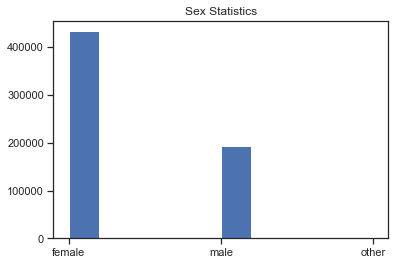

In [78]:
#sex statistics
plt.title('Sex Statistics')
plt.hist(df['sex'])

(array([360420.,  11077.,  36020.,      0.,  29404.,  37281.,      0.,
         59968.,  54183.,  40252.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

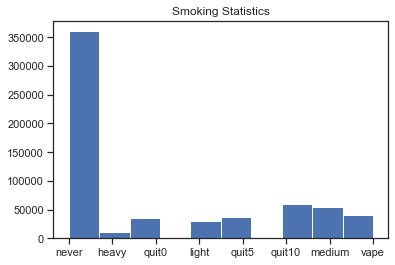

In [79]:
#smoking statistics
plt.title('Smoking Statistics')
plt.hist(df['smoking'])

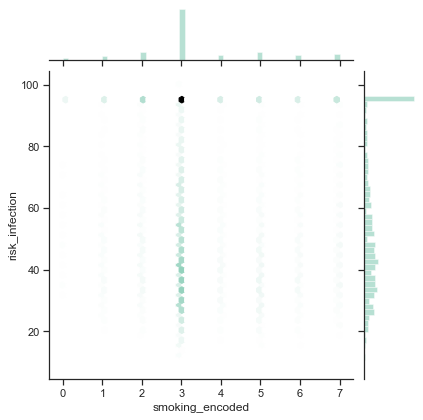

In [80]:
#correlation of smoking with infection risk 

sns.set(style="ticks")
sns.jointplot(df['smoking_encoded'], df['risk_infection'], kind="hex", color="#4CB391")

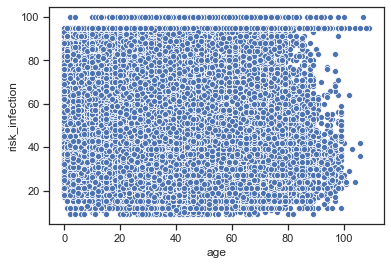

In [81]:
#age vs infection
sns.scatterplot(x='age',y='risk_infection',data=df)

'sns.kdeplot(X[0], ax=ax1)\nsns.kdeplot(X[0], ax=ax1)\nsns.kdeplot(X[0], ax=ax1)'

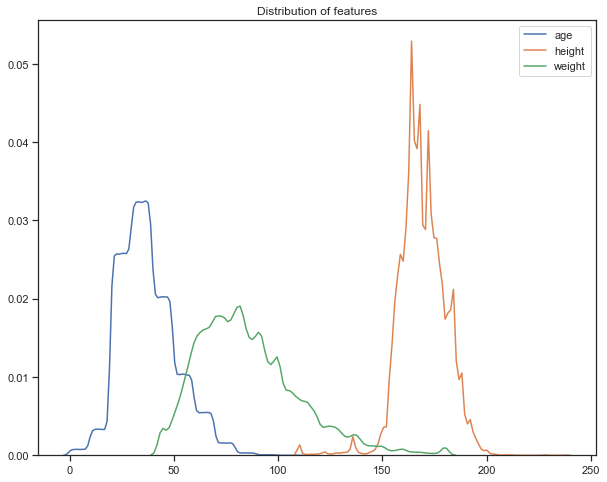

In [166]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Distribution of features')

sns.kdeplot(df['age'], ax=ax1)
sns.kdeplot(df['height'], ax=ax1)
sns.kdeplot(df['weight'], ax=ax1)
"""sns.kdeplot(X[0], ax=ax1)
sns.kdeplot(X[0], ax=ax1)
sns.kdeplot(X[0], ax=ax1)"""

### 7) Preparing Data to feed to Deep Learning model

In [82]:
X = df[['sex_encoded', 'age', 'height', 'weight', 'blood_type_encoded',
       'smoking_encoded', 'alcohol', 'cannabis', 'amphetamines', 'cocaine', 'lsd',
       'mdma', 'contacts_count', 'house_count',
       'rate_government_action', 'rate_reducing_risk_single',
       'rate_reducing_risk_house', 'rate_reducing_mask',
       'covid19_symptoms', 'covid19_contact', 'asthma', 'kidney_disease',
       'compromised_immune', 'heart_disease', 'lung_disease', 'diabetes',
       'hiv_positive', 'hypertension', 'other_chronic']]

In [83]:
in_list =['sex_encoded', 'age', 'height', 'weight', 'blood_type_encoded',
       'smoking_encoded', 'alcohol', 'cannabis', 'amphetamines', 'cocaine', 'lsd',
       'mdma', 'contacts_count', 'house_count',
       'rate_government_action', 'rate_reducing_risk_single',
       'rate_reducing_risk_house', 'rate_reducing_mask',
       'covid19_symptoms', 'covid19_contact', 'asthma', 'kidney_disease',
       'compromised_immune', 'heart_disease', 'lung_disease', 'diabetes',
       'hiv_positive', 'hypertension', 'other_chronic','risk_infection', 'risk_mortality']

for i in in_list:
    print("unique values for {}: {}".format(i,df[i].unique()))

unique values for sex_encoded: [0 1 2]
unique values for age: [ 48  36  21  20  64  18  47  43  67  40  45  46  24  33  26  65  30  53
  85  34  27  44  66  75  31  22  37  61  28  49  29  54  41  58  57  50
  23  35  39  59  32  78   7  25  63  69  42  38  52  13  56  16  17  62
   4   3  68  77  14  51  76  55  71  15  79  60  12  74  11   0  73  89
  19  10   5   6  88  72   2   8  86  81  82  84   9  70   1  83  80  87
  90  95  96  99  92  98  91  94  93  97 109 101 104 102 106 108 100 103
 107]
unique values for height: [168 164 158 166 154 156 178 170 182 172 192 134 174 160 162 176 180 150
 188 184 152 122 190 148 194 110 186 198 196 146 136 144 128 138 204 200
 118 142 126 130 206 124 226 140 116 202 212 132 238 218 214 120 112 114
 208 228 210 234 222 232 230 216 236 224 220]
unique values for weight: [ 80 110  70  98 106  86  78  58 100 114  68  66 152  88  82  92  76  94
  72  56  96  54  84 122 116 138  60  62  48 112  74 118 104  64  90 164
 144  52  44  50 108 102 142 13

In [84]:
y = df[['risk_infection', 'risk_mortality']]

In [48]:

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [71]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

In [162]:
len(df)

29

## Training a Classical Machine Learning model - Random Forest Regressor

In [143]:

rfc = RandomForestRegressor(verbose=42)
regr = MultiOutputRegressor(rfc)

In [144]:
regr.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.6s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.7s remaining:    0.0s


building tree 5 of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.9s remaining:    0.0s


building tree 6 of 100


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   50.0s remaining:    0.0s


building tree 7 of 100


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   58.2s remaining:    0.0s


building tree 8 of 100


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


building tree 9 of 100


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


building tree 10 of 100


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min remaining:    0.0s


building tree 11 of 100


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  1.5min remaining:    0.0s


building tree 12 of 100


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.7min remaining:    0.0s


building tree 13 of 100


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  1.8min remaining:    0.0s


building tree 14 of 100


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  1.9min remaining:    0.0s


building tree 15 of 100


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.1min remaining:    0.0s


building tree 16 of 100


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  2.2min remaining:    0.0s


building tree 17 of 100


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  2.3min remaining:    0.0s


building tree 18 of 100


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.5min remaining:    0.0s


building tree 19 of 100


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  2.6min remaining:    0.0s


building tree 20 of 100


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.7min remaining:    0.0s


building tree 21 of 100


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  2.9min remaining:    0.0s


building tree 22 of 100


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  3.0min remaining:    0.0s


building tree 23 of 100


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  3.1min remaining:    0.0s


building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  3.3min remaining:    0.0s


building tree 25 of 100


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.4min remaining:    0.0s


building tree 26 of 100


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  3.5min remaining:    0.0s


building tree 27 of 100


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.7min remaining:    0.0s


building tree 28 of 100


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  3.8min remaining:    0.0s


building tree 29 of 100


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  3.9min remaining:    0.0s


building tree 30 of 100


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.1min remaining:    0.0s


building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:  4.2min remaining:    0.0s


building tree 32 of 100


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  4.4min remaining:    0.0s


building tree 33 of 100


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  4.5min remaining:    0.0s


building tree 34 of 100


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  4.6min remaining:    0.0s


building tree 35 of 100


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  4.8min remaining:    0.0s


building tree 36 of 100


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.9min remaining:    0.0s


building tree 37 of 100


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  5.0min remaining:    0.0s


building tree 38 of 100


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  5.2min remaining:    0.0s


building tree 39 of 100


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  5.3min remaining:    0.0s


building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  5.4min remaining:    0.0s


building tree 41 of 100


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  5.6min remaining:    0.0s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 13.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.9s remaining:    0.0s


building tree 5 of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.1s remaining:    0.0s


building tree 6 of 100


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   42.2s remaining:    0.0s


building tree 7 of 100


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   49.2s remaining:    0.0s


building tree 8 of 100


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   56.3s remaining:    0.0s


building tree 9 of 100


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


building tree 10 of 100


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min remaining:    0.0s


building tree 11 of 100


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  1.3min remaining:    0.0s


building tree 12 of 100


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.4min remaining:    0.0s


building tree 13 of 100


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  1.5min remaining:    0.0s


building tree 14 of 100


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  1.6min remaining:    0.0s


building tree 15 of 100


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.8min remaining:    0.0s


building tree 16 of 100


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.9min remaining:    0.0s


building tree 17 of 100


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  2.0min remaining:    0.0s


building tree 18 of 100


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.1min remaining:    0.0s


building tree 19 of 100


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  2.2min remaining:    0.0s


building tree 20 of 100


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min remaining:    0.0s


building tree 21 of 100


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  2.5min remaining:    0.0s


building tree 22 of 100


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  2.6min remaining:    0.0s


building tree 23 of 100


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  2.7min remaining:    0.0s


building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.8min remaining:    0.0s


building tree 25 of 100


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.9min remaining:    0.0s


building tree 26 of 100


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  3.0min remaining:    0.0s


building tree 27 of 100


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.1min remaining:    0.0s


building tree 28 of 100


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  3.3min remaining:    0.0s


building tree 29 of 100


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  3.4min remaining:    0.0s


building tree 30 of 100


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.5min remaining:    0.0s


building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:  3.6min remaining:    0.0s


building tree 32 of 100


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  3.7min remaining:    0.0s


building tree 33 of 100


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  3.8min remaining:    0.0s


building tree 34 of 100


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  4.0min remaining:    0.0s


building tree 35 of 100


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  4.1min remaining:    0.0s


building tree 36 of 100


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.2min remaining:    0.0s


building tree 37 of 100


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  4.3min remaining:    0.0s


building tree 38 of 100


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  4.4min remaining:    0.0s


building tree 39 of 100


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  4.6min remaining:    0.0s


building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.7min remaining:    0.0s


building tree 41 of 100


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  4.8min remaining:    0.0s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.9min finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                              

In [145]:
len(regr.estimators_)

2

In [146]:
regr.estimators_[0].feature_importances_

array([5.26073969e-04, 4.41468690e-03, 3.29572885e-03, 4.12722383e-03,
       1.93210866e-03, 1.58515478e-03, 2.42012335e-03, 1.30664154e-03,
       3.75718643e-04, 3.49656275e-04, 2.61200212e-04, 3.05314812e-04,
       8.24333832e-01, 3.35364101e-02, 1.22339444e-03, 6.06313595e-03,
       7.99050646e-02, 9.24364594e-03, 7.75593569e-03, 1.52419493e-02,
       4.51212070e-04, 3.58569955e-05, 2.40196065e-04, 9.02056463e-05,
       6.17861518e-05, 2.41495091e-04, 4.72971700e-05, 3.59360500e-04,
       2.69590186e-04])

In [147]:
y_pred = regr.predict(X_test)

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  1

In [148]:
regr.score(X_test,y_test)

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  1

0.9847496296305971

In [505]:
df.iloc[500041]

sex                          female
age                              55
height                          158
weight                           62
blood_type                       on
smoking                       never
alcohol                           0
cannabis                         -1
amphetamines                     -1
cocaine                          -1
lsd                              -1
mdma                             -1
contacts_count                    5
house_count                       4
rate_government_action            2
rate_reducing_risk_single         5
rate_reducing_risk_house          5
rate_reducing_mask                3
covid19_symptoms                  0
covid19_contact                   0
asthma                            1
kidney_disease                    0
compromised_immune                0
heart_disease                     0
lung_disease                      1
diabetes                          1
hiv_positive                      0
hypertension                

In [506]:
test_pred = regr.predict(X_[500041].reshape(1,29))

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  1

In [507]:
sc_y.inverse_transform(test_pred)

array([[31.99      , 19.92080833]])

In [306]:
#saving the model

joblib.dump(regr, 'model_severity/regr.pkl') 

['model_severity/regr.pkl']

In [598]:
scaler_x = open('model_severity/standard_scaler_x.pkl', 'wb')
pickle.dump(sc_X, scaler_x)
scaler_x.close()

In [600]:
scaler_y = open('model_severity/standard_scaler_y.pkl', 'wb')
pickle.dump(sc_y, scaler_y)
scaler_y.close()

## Define Neural Network Model parameters

In [514]:
mcp = ModelCheckpoint("/checkpoint", monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

In [197]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.0001):
      print("\nReached 100% accuracy so cancelling training!")
      self.model.stop_training = True

In [198]:
cb = myCallback()

In [89]:
logdir = "tensorboard_logs\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
mm_scaler_x = MinMaxScaler(feature_range=(0,1))
mm_scaler_y = MinMaxScaler(feature_range=(0,1))

X_mm = mm_scaler_x.fit_transform(X)
y_mm = mm_scaler_y.fit_transform(y)

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split( X_mm, y_mm, test_size=0.15)

In [94]:
epochs = 500

In [ ]:
history = History()

## Train first Neural Network model


In [247]:
model_3 = Sequential()
model_3.add(Dense(1024,input_dim=X_train_.shape[1], init='normal',activation='relu'))#,activation = 'LeakyRelu'))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5))
model_3.add(Dense(512, init='normal',activation='relu'))
#model.add(LeakyReLU(alpha=0.1))

model_3.add(Dense(256, init='normal',activation='relu'))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5))
model_3.add(Dense(128, init='normal',activation='relu'))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.2))
#model.add(Dense(512, init='uniform'))
#model.add(LeakyReLU(alpha=0.05))
#model.add(Dense(256, init='uniform'))
#model.add(LeakyReLU(alpha=0.05))
#model.add(Dropout(0.2))
#model.add(Dense(128, init='uniform'))
#model.add(LeakyReLU(alpha=0.05))
model_3.add(Dense(2, activation = 'linear'))
model_3.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])


d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, input_dim=29, activation="relu", kernel_initializer="normal")`
  
d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal")`
  """
d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  
d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
  # This is added back by InteractiveShellApp.init_path()


In [248]:
hist = model_3.fit(X_train_, y_train_, nb_epoch=500,validation_split=0.15,batch_size= 128,callbacks=[cb,tensorboard_callback,history])

d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 454166 samples, validate on 80148 samples
Epoch 1/500
454166/454166 [==============================] - 22s 47us/step - loss: 0.0030 - mae: 0.0295 - val_loss: 0.0014 - val_mae: 0.0206
Epoch 2/500
454166/454166 [==============================] - 21s 47us/step - loss: 0.0011 - mae: 0.0191 - val_loss: 0.0011 - val_mae: 0.0176
Epoch 3/500
454166/454166 [==============================] - 21s 46us/step - loss: 0.0010 - mae: 0.0176 - val_loss: 9.8276e-04 - val_mae: 0.0153
Epoch 4/500
454166/454166 [==============================] - 21s 46us/step - loss: 0.0010 - mae: 0.0169 - val_loss: 9.4990e-04 - val_mae: 0.0159
Epoch 5/500
454166/454166 [==============================] - 21s 46us/step - loss: 9.8150e-04 - mae: 0.0165 - val_loss: 0.0013 - val_mae: 0.0224
Epoch 6/500
454166/454166 [==============================] - 21s 46us/step - loss: 9.6881e-04 - mae: 0.0163 - val_loss: 9.8789e-04 - val_mae: 0.0183
Epoch 7/500
454166/454166 [==============================] - 21s 47us/step - loss: 

KeyboardInterrupt: 

In [253]:
print(history.history)

{'val_loss': [0.0014218258842486212, 0.0011314882623665167, 0.0009827645911072208, 0.0009498959121764188, 0.0013226716071489042, 0.0009878878798971174, 0.0009362549200426417, 0.0010572763199448942, 0.0008969072083059911, 0.001062456066671151, 0.0010825680174744027, 0.0008911813380724333, 0.0009152772728146531, 0.0009805978108251368, 0.000878103182108168, 0.0008953856454317089, 0.0012245390195162566, 0.001198504464761707, 0.001059726583544933, 0.0008995007363488222], 'val_mae': [0.020563678815960884, 0.017633438110351562, 0.015305504202842712, 0.015948479995131493, 0.022361453622579575, 0.018277421593666077, 0.015816528350114822, 0.020237881690263748, 0.01587129943072796, 0.019925273954868317, 0.02001560665667057, 0.016255075111985207, 0.017068656161427498, 0.015541167929768562, 0.014804139733314514, 0.015134170651435852, 0.018383221700787544, 0.02090124599635601, 0.01660342328250408, 0.013901031576097012], 'loss': [0.003020806065797382, 0.001137101604211632, 0.0010400763979461862, 0.00

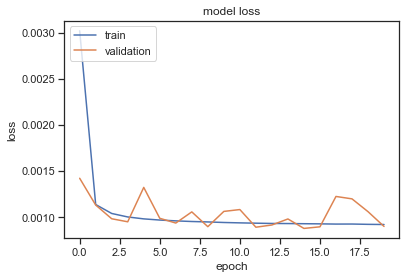

In [254]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [255]:
model_3.save("model_severity/"+"model_severity_3.h5")

In [257]:
eval_ = model_3.evaluate(X_test_,y_test_)
print("mse: {}  ,  mae: {}".format(eval_[0],eval_[1]))

94291/94291 [==============================] - 7s 75us/step
mse: 0.0009228609178257421  ,  mae: 0.016370095312595367


In [660]:
df.iloc[612345]

sex                           female
age                               25
height                           170
weight                            56
blood_type                   unknown
smoking                         vape
alcohol                            3
cannabis                           0
amphetamines                      -1
cocaine                           -1
lsd                               -1
mdma                              -1
contacts_count                     6
house_count                        4
rate_government_action             3
rate_reducing_risk_single          4
rate_reducing_risk_house           2
rate_reducing_mask                 2
covid19_symptoms                   0
covid19_contact                    0
asthma                             0
kidney_disease                     0
compromised_immune                 1
heart_disease                      0
lung_disease                       0
diabetes                           0
hiv_positive                       0
h

In [548]:
test_pred = model_3.predict(X_mm[612345].reshape(1,29))

In [549]:
predictions = mm_scaler_y.inverse_transform(test_pred)

In [550]:
list(predictions)

[array([33.104927  ,  0.81059396], dtype=float32)]

In [281]:
print("Risk of infection: {},\nRisk of Mortality: {}".format(list(predictions)[0][0],list(predictions)[0][1]))

Risk of infection: 78.30826568603516,
Risk of Mortality: 8.923952102661133


## Training Second Neural Network Model

In [616]:
model_4 = Sequential()
#model_4.add(Dense(1024,input_dim=X_train_.shape[1], init='normal',activation='relu'))#,activation = 'LeakyRelu'))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5))
#model_4.add(Dense(64,input_dim=X_train_.shape[1], init='normal',activation='relu'))
model_4.add(Dense(32, input_dim=X_train_.shape[1],init='normal',activation='relu'))
model_4.add(Dense(16, init='normal',activation='relu'))

model_4.add(Dense(2, init='normal'))
model_4.compile(loss='mse', optimizer='adam', metrics=['mae'])

d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, input_dim=29, activation="relu", kernel_initializer="normal")`
  
d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="normal")`
  import sys
d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, kernel_initializer="normal")`


In [617]:
hist = model_4.fit(X_train_, y_train_, nb_epoch=500,validation_split=0.17,batch_size=32,callbacks=[mcp,cb,tensorboard_callback,history])

d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 443480 samples, validate on 90834 samples
Epoch 1/500
443480/443480 [==============================] - 116s 261us/step - loss: 0.0022 - mae: 0.0243 - val_loss: 0.0012 - val_mae: 0.0198
Epoch 2/500
443480/443480 [==============================] - 116s 262us/step - loss: 0.0011 - mae: 0.0192 - val_loss: 0.0010 - val_mae: 0.0185
Epoch 3/500
443480/443480 [==============================] - 116s 262us/step - loss: 0.0010 - mae: 0.0177 - val_loss: 0.0011 - val_mae: 0.0167
Epoch 4/500
443480/443480 [==============================] - 116s 262us/step - loss: 9.8509e-04 - mae: 0.0170 - val_loss: 9.4108e-04 - val_mae: 0.0167
Epoch 5/500
 11296/443480 [..............................] - ETA: 1:41 - loss: 0.0010 - mae: 0.0170

KeyboardInterrupt: 

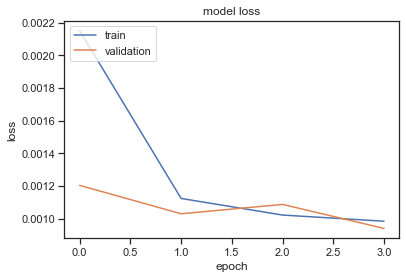

In [618]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [650]:
eval_ = model_4.evaluate(X_test_,y_test_)
print("mse: {}  ,  mae: {}".format(eval_[0],eval_[1]))

94291/94291 [==============================] - 12s 131us/step
mse: 0.0009193778616401299  ,  mae: 0.01612960174679756


In [651]:
model_4.save("model_severity/"+"model_severity_4.h5")

In [649]:
#testing


df.iloc[292929]


sex                           female
age                               48
height                           156
weight                           106
blood_type                   unknown
smoking                        never
alcohol                            5
cannabis                          -1
amphetamines                      -1
cocaine                           -1
lsd                               -1
mdma                              -1
contacts_count                     2
house_count                        2
rate_government_action             1
rate_reducing_risk_single          4
rate_reducing_risk_house           1
rate_reducing_mask                 2
covid19_symptoms                   0
covid19_contact                    0
asthma                             1
kidney_disease                     0
compromised_immune                 0
heart_disease                      0
lung_disease                       0
diabetes                           0
hiv_positive                       0
h

In [646]:
test_pred = model_4.predict(X_mm[292929].reshape(1,29))

In [647]:
test_pred

array([[0.49640274, 0.01249734]], dtype=float32)

In [654]:
predictions = mm_scaler_y.inverse_transform(test_pred)

In [655]:
print("Risk of infection: {},\nRisk of Mortality: {}".format(list(predictions)[0][0],list(predictions)[0][1]))

Risk of infection: 54.17264938354492,
Risk of Mortality: 1.6809982061386108


In [ ]:
#saving scalers

In [652]:
scaler_x = open('model_severity/minmax_x.pkl', 'wb')
pickle.dump(mm_scaler_x, scaler_x)
scaler_x.close()

In [653]:
scaler_y = open('model_severity/minmax_y.pkl', 'wb')
pickle.dump(mm_scaler_y, scaler_y)
scaler_y.close()